# Seeing how much data is lost by the scRNA HiC data

In [137]:
library(dplyr)
wanted <- read.table('/extra/repos/jupyter/wolff_2019/wanted.txt', stringsAsFactors = F)
full <- read.table('/extra/repos/jupyter/wolff_2019/fold2.txt', stringsAsFactors = F)

In [141]:
message("Full ls output:")
head(full)

message("Convert into a format we want:")
full.bare <- full %>%
    mutate(name=sub(".fastq","",V9)) %>%
    mutate(read=sub(".*_.*_","",name)) %>%
    mutate(name=sub("_R.*","",name)) %>%
    select(name,read,size=V5)

full.bare %>% head()

Full ls output:


V1,V2,V3,V4,V5,V6,V7,V8,V9
-rw-rw-r--,1,wolffj,wolffj,33K,Apr,17,17:13,AAAAAAAA_AAAAAAAA_R1.fastq
-rw-rw-r--,1,wolffj,wolffj,33K,Apr,17,17:13,AAAAAAAA_AAAAAAAA_R2.fastq
-rw-rw-r--,1,wolffj,wolffj,359,Apr,17,17:06,AAAAAAAA_AAAAAAAT_R1.fastq
-rw-rw-r--,1,wolffj,wolffj,359,Apr,17,17:06,AAAAAAAA_AAAAAAAT_R2.fastq
-rw-rw-r--,1,wolffj,wolffj,358,Apr,17,17:02,AAAAAAAA_AAAAAATA_R1.fastq
-rw-rw-r--,1,wolffj,wolffj,358,Apr,17,17:02,AAAAAAAA_AAAAAATA_R2.fastq


Convert into a format we want:


name,read,size
AAAAAAAA_AAAAAAAA,R1,33K
AAAAAAAA_AAAAAAAA,R2,33K
AAAAAAAA_AAAAAAAT,R1,359
AAAAAAAA_AAAAAAAT,R2,359
AAAAAAAA_AAAAAATA,R1,358
AAAAAAAA_AAAAAATA,R2,358


In [142]:
message("Barcodes output:")
head(wanted)

message("Convert it into a format we want:")
want.bare <- wanted %>% mutate(wanted_name=paste(V3,"_",V4, sep=""))  %>% select(wanted_name)
want.bare %>% head()

Barcodes output:


V1,V2,V3,V4,V5,V6
kDiploid_15_16_17_18,4363,AGGCAGAA,ACTGCATA,1CDX4-3,Diploid_18
Diploid_15_16_17_18,4363,AGGCAGAA,CTCTCTAT,1CDX1-3,Diploid_15
Diploid_15_16_17_18,4363,AGGCAGAA,GTAAGGAG,1CDX3-3,Diploid_17
Diploid_15_16_17_18,4363,AGGCAGAA,TATCCTCT,1CDX2-3,Diploid_16
Diploid_15_16_17_18,4363,CGTACTAG,ACTGCATA,1CDX4-2,Diploid_18
Diploid_15_16_17_18,4363,CGTACTAG,CTCTCTAT,1CDX1-2,Diploid_15


Convert it into a format we want:


wanted_name
AGGCAGAA_ACTGCATA
AGGCAGAA_CTCTCTAT
AGGCAGAA_GTAAGGAG
AGGCAGAA_TATCCTCT
CGTACTAG_ACTGCATA
CGTACTAG_CTCTCTAT


In [143]:
message("Merge full set with wanted:")
full <- full.bare %>% mutate(wanted=full.bare$name %in% want.bare$wanted_name) 
full %>% filter(wanted==T) %>% head()


Merge full set with wanted:


name,read,size,wanted
AGGCAGAA_ACTGCATA,R1,189M,TRUE
AGGCAGAA_ACTGCATA,R2,189M,TRUE
AGGCAGAA_CTCTCTAT,R1,205M,TRUE
AGGCAGAA_CTCTCTAT,R2,205M,TRUE
AGGCAGAA_GTAAGGAG,R1,180M,TRUE
AGGCAGAA_GTAAGGAG,R2,180M,TRUE


In [144]:
convSingle <- function(array, unit){
    tmp = sub(",",".",array)
    tmp = sub(unit,"",tmp)
    tmp = as.numeric(tmp)
    if (unit == "K"){
        tmp = tmp * 1e3
    } else if (unit == "M" ){
        tmp = tmp * 1e6        
    } else if (unit == "G" ){
        tmp = tmp * 1e9        
    }
    return(tmp)
}

convAll <- function(array){
    tmp <- array
    tmp$bytes <- tmp$size
    just.ks <- grepl("K",tmp$bytes)
    just.ms <- grepl("M",tmp$bytes)
    just.gs <- grepl("G",tmp$bytes)
    
    vals.ks <- convSingle(tmp[just.ks,]$bytes, "K")
    vals.ms <- convSingle(tmp[just.ms,]$bytes, "M")
    vals.gs <- convSingle(tmp[just.gs,]$bytes, "G")
    
    tmp[just.ks,]$bytes <- vals.ks
    tmp[just.ms,]$bytes <- vals.ms
    tmp[just.gs,]$bytes <- vals.gs    
    tmp$bytes <- as.numeric(tmp$bytes)
    return(tmp)
}

In [145]:
message("Convert all sizes into bytes")
full.n <- convAll(full)
head(full.n)

Convert all sizes into bytes


name,read,size,wanted,bytes
AAAAAAAA_AAAAAAAA,R1,33K,FALSE,33000
AAAAAAAA_AAAAAAAA,R2,33K,FALSE,33000
AAAAAAAA_AAAAAAAT,R1,359,FALSE,359
AAAAAAAA_AAAAAAAT,R2,359,FALSE,359
AAAAAAAA_AAAAAATA,R1,358,FALSE,358
AAAAAAAA_AAAAAATA,R2,358,FALSE,358


In [190]:
message("Remove the unneeded size columns:")
full <- full.n %>% select(name, wanted, read, bytes) #%>% mutate(fact=1)
head(full)

Remove the unneeded size columns:


name,wanted,read,bytes
AAAAAAAA_AAAAAAAA,FALSE,R1,33000
AAAAAAAA_AAAAAAAA,FALSE,R2,33000
AAAAAAAA_AAAAAAAT,FALSE,R1,359
AAAAAAAA_AAAAAAAT,FALSE,R2,359
AAAAAAAA_AAAAAATA,FALSE,R1,358
AAAAAAAA_AAAAAATA,FALSE,R2,358


In [230]:
library(ggplot2)
p <- ggplot(full, aes(x = "Bytes", color=factor(wanted),y=bytes, shape=factor(read)))

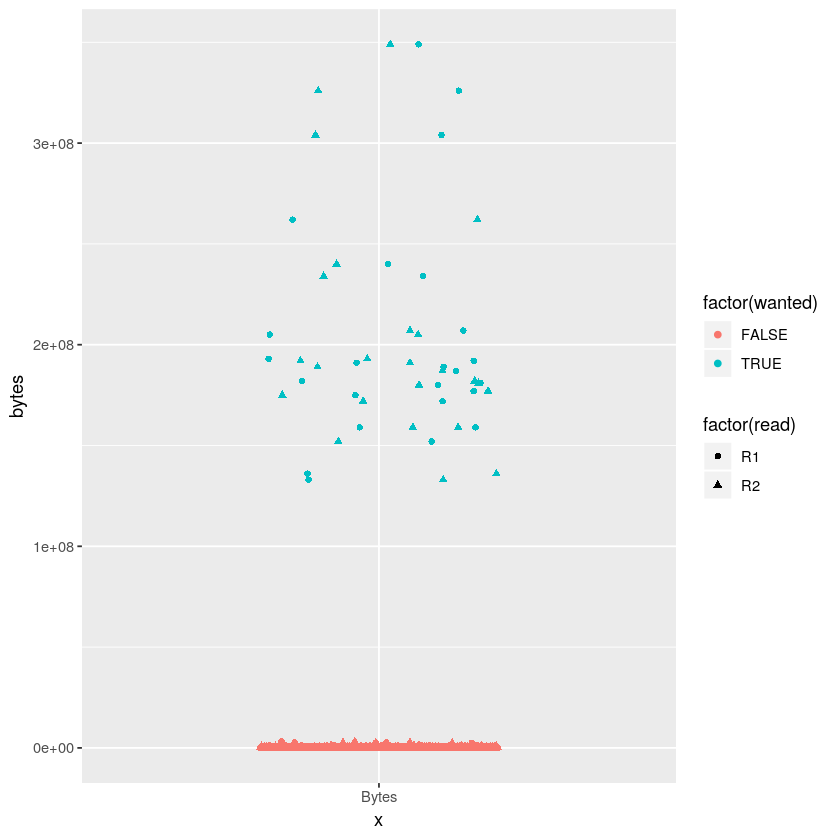

In [231]:
p + geom_jitter(position=position_jitter(0.2))

In [243]:
message("Are all wanted barcodes truly always above 1e08? Yes.")
full %>% filter(wanted==T) %>% arrange(bytes)

Are all wanted barcodes truly always above 1e08? Yes.


name,wanted,read,bytes
TCCTGAGC_GTAAGGAG,TRUE,R1,1.33e+08
TCCTGAGC_GTAAGGAG,TRUE,R2,1.33e+08
TAGGCATG_TATCCTCT,TRUE,R1,1.36e+08
TAGGCATG_TATCCTCT,TRUE,R2,1.36e+08
CGTACTAG_GTAAGGAG,TRUE,R1,1.52e+08
CGTACTAG_GTAAGGAG,TRUE,R2,1.52e+08
GGACTCCT_TATCCTCT,TRUE,R1,1.59e+08
GGACTCCT_TATCCTCT,TRUE,R2,1.59e+08
TAGGCATG_CTCTCTAT,TRUE,R1,1.59e+08
TAGGCATG_CTCTCTAT,TRUE,R2,1.59e+08
